In [1]:
# Import the necessary python modules
import pandas as pd # v.1.4.3
import numpy as np # v.1.23.0

from scipy import stats # v.1.10.1
from sklearn import metrics # v.1.2.2
import rpy2.rinterface as ri # v.3.5.11
from statsmodels.stats.proportion import proportion_confint

import matplotlib.pyplot as plt # v.3.7.1
from matplotlib.ticker import FuncFormatter

from tqdm import tqdm # v.4.65.0

import random # python v.3.9.0
import math
from itertools import combinations

In [2]:
# Change the default font of matplotlib to "Arial"
plt.rcParams.update({"font.family":"Arial",})

In [3]:
# Import the table saved after the data extraction
df_pe = pd.read_excel("sec_PE_data/secondary_PE_final.xlsx") # please see the Jupyter Notebook on the data extraction for how this data was extracted

In [4]:
# creating a formatter that can change axes-labels to percent
def to_percent(value, position):
    return f"{value * 100:.0f}%"

percent_formatter = FuncFormatter(to_percent)

# Grouping primary admission diagnosis for analyses

In [5]:
# get the lists of the patientunitstayids for each admission diagnosis
lst_ids_group_from_OR = list(df_pe[df_pe.admdx_organ_descriptive == "surgery"].patientunitstayid.unique())
lst_ids_infection = list(df_pe[(df_pe.admdx_organ_descriptive != "surgery") & 
                               df_pe.admdx_non_op_dx.str.contains("sepsis|pneumonia|cholangiti|endocarditis|infection|mening|encephaliti", case=False, regex=True)]
                         .patientunitstayid.unique())
lst_ids_cards = list(df_pe[~df_pe.patientunitstayid.isin(lst_ids_group_from_OR+lst_ids_infection) &
                                 (df_pe.admdx_non_op_organsystem == "Cardiovascular")].patientunitstayid.unique())
lst_ids_other = list(df_pe[~df_pe.patientunitstayid.isin(lst_ids_group_from_OR+lst_ids_infection+lst_ids_cards)].patientunitstayid.unique())

In [6]:
# Add a column that will denote the admission diagnosis categories
df_pe["admdx_grouped_analyses"] = "diagnosis_placeholder"

df_pe.loc[df_pe.patientunitstayid.isin(lst_ids_group_from_OR), "admdx_grouped_analyses"] = "Post-operative"
df_pe.loc[df_pe.patientunitstayid.isin(lst_ids_infection), "admdx_grouped_analyses"] = "Infectious"
df_pe.loc[df_pe.patientunitstayid.isin(lst_ids_cards), "admdx_grouped_analyses"] = "Cardiovascular"
df_pe.loc[df_pe.patientunitstayid.isin(lst_ids_other), "admdx_grouped_analyses"] = "Other"

In [7]:
# split off dataframes for each of the four subgroups
df_admdx_surgery = df_pe[df_pe.patientunitstayid.isin(lst_ids_group_from_OR)].copy()
df_admdx_infection = df_pe[df_pe.patientunitstayid.isin(lst_ids_infection)].copy()
df_admdx_cards = df_pe[df_pe.patientunitstayid.isin(lst_ids_cards)].copy()
df_admdx_other = df_pe[df_pe.patientunitstayid.isin(lst_ids_other)].copy()

# Descriptive statistics for the 4 groups

In [8]:
# Number of patients in each subgroups
df_pe["admdx_grouped_analyses"].value_counts()

admdx_grouped_analyses
Other             273
Infectious        260
Cardiovascular    214
Post-operative     65
Name: count, dtype: int64

In [9]:
# Function to calculate mortality rate + confidence interval
def calculate_mortality_confidence_interval(group):
    mortality_rate = group.hospitaldischargestatus.sum() / len(group)
    conf_int = proportion_confint(group.hospitaldischargestatus.sum(), len(group), alpha=0.05)
    return pd.Series({'Mortality Rate': round(mortality_rate * 100, 1),
                      '95% CI Lower': round(conf_int[0] * 100, 1),
                      '95% CI Upper': round(conf_int[1] * 100, 1)})

# Group by admdx_grouped_analyses and apply the function
mortality_stats = df_pe.groupby('admdx_grouped_analyses').apply(calculate_mortality_confidence_interval)

mortality_stats

,Mortality Rate,95% CI Lower,95% CI Upper
admdx_grouped_analyses,,,
Cardiovascular,21.5,16.0,27.0
Infectious,18.5,13.7,23.2
Other,16.1,11.8,20.5
Post-operative,18.5,9.0,27.9


# Tables

## Functions

In [10]:
# A function on how to do a Fisher Exact test via R from python as there is no Fisher Exact test 
# implemented in Python for a contigency table larger than 2x2
def fisher_test_from_contingency_table_rinterface(contingency_table):
    """
    Perform a Fisher Exact test via R on a contigency table and return the p-value. This is mainly
    design for larger contigency tables (> 2x2) as a Fisher Exact test for these is not implemented 
    in Python, yet.
    
    :param contingency_table: Dataframe - contingency table
    
    :return: p-value (float)
    
    """
    # Ensure all index and column labels in the contingency table are strings
    contingency_table.index = contingency_table.index.astype(str)
    contingency_table.columns = contingency_table.columns.astype(str)

    # Activate R bindings
    ri.initr()

    # Convert the contingency table to an R-friendly format
    data_values = ri.FloatSexpVector(contingency_table.values.flatten())
    row_labels = ri.StrSexpVector(contingency_table.index.values)
    col_labels = ri.StrSexpVector(contingency_table.columns.values)
    num_rows = contingency_table.shape[0]
    num_cols = contingency_table.shape[1]

    # Define and evaluate the R script
    # The function switches to p-value approximation if the exact p-value calculation exceeds
    # a workspace of 2e7 (for larger contigency tables e.g. 2x9)
    r_script = f"""
    library(stats)

    matrix_r <- matrix(c({','.join(map(str, data_values))}),
                       nrow = {num_rows}, ncol = {num_cols}, byrow = TRUE)
    colnames(matrix_r) <- c({','.join(map(lambda x: f'"{x}"', col_labels))})
    rownames(matrix_r) <- c({','.join(map(lambda x: f'"{x}"', row_labels))})
    contingency_table_r <- as.data.frame(matrix_r)

    tryCatch(
      {{
        result <- fisher.test(contingency_table_r, workspace = 2e7)  # Increase workspace size
        p_value <- result$p.value
        p_value
      }},
      error = function(e){{
        # Catch the workspace error and perform the simulation
        result <- fisher.test(contingency_table_r, simulate.p.value = TRUE)
        p_value <- result$p.value
        p_value
      }}
    )
    """

    # Execute the R script and get the p-value
    p_value = ri.baseenv['eval'](ri.parse(text=r_script))[0]

    # Return the p-value as a float
    return float(p_value)


def agg_binary_count_and_percentage(x):
    """ aggregating function for the binary variables, producing a count and percentage """
    if x.empty:
        return np.nan

    val_cnt = x.dropna().value_counts()

    if 1 not in val_cnt.index:
        return "0 (0%)"

    ones_count = val_cnt.at[1]

    ones_percentage = x.value_counts(normalize=True).at[1] * 100
    ones_percentage = round(ones_percentage, 1)

    return "{} ({}%)".format(ones_count, ones_percentage)


def agg_missing_w_percentage(x):
    """ aggregating function for the missing values, produces a count and a percentage """
    n_missing = x.isna().sum()
    missing_percent = round(((x.isna().sum() / len(x)) * 100), 1)
    return "{} ({}%)".format(n_missing, missing_percent)


def agg_continuous_median_and_iqr(x):
    """ aggregating function for the continuous variables, produces a median and Q25-Q75 """
    if x.empty:
        return np.nan

    quantiles_cont = x.dropna().quantile(q=[0.25, 0.5, 0.75])
    quantiles = [quantiles_cont[0.25], quantiles_cont[0.50], quantiles_cont[0.75]]

    return "{} [{}-{}]".format(round(quantiles[1], 1), round(quantiles[0], 1), round(quantiles[2], 1))
    

def demographics_w_missing_cat_advanced(df_data, diff_clm, lst_binary=None, lst_continuous=None, lst_categories=None, diff_ind=1):
    """
    Creates a formatted overview of how many patients had which feature/variable and then splitting that into 2 groups (typically survivors vs
    non-survivors) and computing a comparison for that. Continuous data are presented as median and IQR while categorical and binary variables as count and percentage. 
    Categorical and binary variables are compared by Chi-Square test or Fisher-Exact test (if any observation is <5). 
    Continuous variables were tested for normal distribution via Shapiro-Wilk test and compared by independent t-test if normally distributed or Mann-Whitney-U test 
    if either group is not normally distributed. For categorical data, a Fisher Exact/Chi-Square test is calculated over all the categories.
    Missing data is shown as percentage.

    :param df_vars: Dataframe - with the data, the different features/variables should be columns
    
    :param lst_binary: List - list of the columns labels with binary Data
        
    :param lst_continuous: List - list of the column names with continuous Data

    :param diff_clm: String - name of the differentiator column (for the comparison)

    :param diff_ind: String/int/float, preset 1 - indicator that markes the one of two groups in the diff_clm currenlty primarily stable/optimized for the int 1

    :return: Dataframe 
    """

    if lst_binary is None:
        lst_binary = []
    if lst_continuous is None:
        lst_continuous = []
    if lst_categories is None:
        lst_categories = []

    if len(lst_binary) > 0:
        lst_binary.append(diff_clm)
    lst_final_dfs = []
    
    # initiate the dataframes for the binary and continuous variables
    df_binary = pd.DataFrame(
        columns=["All patients", "All_pat_missing_data", "Survivors", "Survivors_missing_data", "Non_survivors",
                 "Non_survivors_missing_data", "p-value", "test"], index=lst_binary)
    df_continuous = pd.DataFrame(
        columns=["All patients", "All_pat_missing_data", "Survivors", "Survivors_missing_data", "Non_survivors",
                 "Non_survivors_missing_data", "p-value", "test"],
        index=lst_continuous)

    ## binary variables
    # summarize the binary variables if they are entered
    if len(lst_binary) > 0:
        # summarize the binary variables for the whole cohort
        result_all_binary = df_data[lst_binary].apply(lambda x: agg_binary_count_and_percentage(x))
        df_binary.loc[:, "All patients"] = result_all_binary
        
        # summarize the binary variables for the 2 groups (survivors vs non-survivors)
        result_split_binary = (df_data[lst_binary].groupby(diff_clm)
                               .agg([agg_binary_count_and_percentage])
                               .droplevel(level=1, axis=1)
                               .transpose()
                               .rename(columns={0: "Survivors", 1: "Non_survivors"}))
        df_binary.loc[:, ["Survivors", "Non_survivors"]] = result_split_binary

        # calculate and add the p-values for the binary variables (looping over those variables)
        for clm_binary in lst_binary:
            df_contigency = pd.crosstab(df_data[clm_binary], df_data[diff_clm])
            
            # if any field of the contingency table is < 5 then use the Fisher Exact test, otherwise the Chi-Square test
            if (df_contigency < 5).any().any() == True:
                fisher_statistic, fisher_pvalue = stats.fisher_exact(df_contigency)
                p_value = fisher_pvalue
                test_name = "Fisher Exact"
            else:
                chi_statistic, chi_pvalue, chi_dof, chi_expec = stats.chi2_contingency(df_contigency)
                p_value = chi_pvalue
                test_name = "Chi-Square"

            if p_value < 0.001:
                p_value = "< 0.001"
            else:
                p_value = round(p_value, 3)

            df_binary.loc[clm_binary, "p-value"] = p_value
            df_binary.loc[clm_binary, "test"] = test_name

        df_binary.loc[df_binary.Survivors.isna() | df_binary.Non_survivors.isna(), ["p-value", "test"]] = np.nan

        # add the count of missing data for binary variables (whole cohort, survivors, non-survivors)
        all_binary_missing = df_data[lst_binary].apply(lambda x: agg_missing_w_percentage(x))
        df_binary.loc[:, "All_pat_missing_data"] = all_binary_missing

        diff_binary_missing = df_data.loc[df_data[diff_clm] == diff_ind, lst_binary].apply(
            lambda x: agg_missing_w_percentage(x))
        df_binary.loc[:, "Non_survivors_missing_data"] = diff_binary_missing

        anti_diff_binary_missing = df_data.loc[df_data[diff_clm] != diff_ind, lst_binary].apply(
            lambda x: agg_missing_w_percentage(x))
        df_binary.loc[:, "Survivors_missing_data"] = anti_diff_binary_missing

        lst_final_dfs.append(df_binary)

    ## continuous variables
    # summarize the continuous variables if they are entered
    if len(lst_continuous) > 0:
        # summarize the continuous variables for the whole cohort
        result_all_continuous = df_data[lst_continuous].apply(lambda x: agg_continuous_median_and_iqr(x))
        df_continuous.loc[:, "All patients"] = result_all_continuous

        # summarize the continuous variables for the 2 groups (survivors vs non-survivors)
        lst_continuous_w_diff = lst_continuous + [diff_clm]

        result_split_continuous = (df_data[lst_continuous_w_diff].groupby(diff_clm)
                                   .agg([agg_continuous_median_and_iqr])
                                   .droplevel(level=1, axis=1)
                                   .transpose()
                                   .rename(columns={0: "Survivors", 1: "Non_survivors"}))
        df_continuous.loc[:, ["Survivors", "Non_survivors"]] = result_split_continuous

        # split the data into 2 dataframes for the 2 groups
        df_diff_clm = df_data.loc[df_data[diff_clm] == diff_ind, lst_continuous].copy()
        df_anti_diff_clm = df_data.loc[df_data[diff_clm] != diff_ind, lst_continuous].copy()

        # calculate and add the p-values for the continuous variables        
        for clm_cont in lst_continuous:
            df_diff_clm_var = df_diff_clm[clm_cont].dropna()
            df_anti_diff_var = df_anti_diff_clm[clm_cont].dropna()
            statistic_shap_0, p_shap_0 = stats.shapiro(df_anti_diff_var)
            statistic_shap_1, p_shap_1 = stats.shapiro(df_diff_clm_var)
            
            # if either data is not normally distributed use a Mann-Whitney-U test, otherwise a Welch's independent t-test 
            if p_shap_0 < 0.05 or p_shap_1 < 0.05:
                df_diff_clm_var_float = df_diff_clm_var.astype(float) 
                df_anti_diff_var_float = df_anti_diff_var.astype(float)

                statistic_mann, p_value_mann = stats.mannwhitneyu(df_anti_diff_var_float, df_diff_clm_var_float)
                p_value = p_value_mann
                test_name = "Mann-Whitney-U"

            else:
                statistic_t, p_value_t = stats.ttest_ind(df_anti_diff_var, df_diff_clm_var, equal_var=False)
                p_value = p_value_t
                test_name = "Independent t-test"

            if p_value < 0.001:
                p_value = "< 0.001"
            else:
                p_value = round(p_value, 3)

            df_continuous.loc[clm_cont, "p-value"] = p_value
            df_continuous.loc[clm_cont, "test"] = test_name

        df_continuous.loc[df_continuous.Survivors.isna() | df_continuous.Non_survivors.isna(), ["p-value", "test"]] = np.nan

        # add the count of missing data for continuous variables (whole cohort, survivors, non-survivors)
        all_continuous_missing = df_data[lst_continuous].apply(lambda x: agg_missing_w_percentage(x))
        df_continuous.loc[:, "All_pat_missing_data"] = all_continuous_missing

        diff_continuous_missing = df_data.loc[df_data[diff_clm] == diff_ind, lst_continuous].apply(
            lambda x: agg_missing_w_percentage(x))
        df_continuous.loc[:, "Non_survivors_missing_data"] = diff_continuous_missing

        anti_diff_continuous_missing = df_data.loc[df_data[diff_clm] != diff_ind, lst_continuous].apply(
            lambda x: agg_missing_w_percentage(x))
        df_continuous.loc[:, "Survivors_missing_data"] = anti_diff_continuous_missing

        lst_final_dfs.append(df_continuous)

    ## categorical variables
    if len(lst_categories) > 0:
        lst_cat_results_dfs = []
        #df_data[lst_categories] = df_data[lst_categories].astype('object')
      
        # iterate over each category, transform them into binary variables per category and calculate the summaries/statistics
        for clm_cat in lst_categories:
            # prepare one category via one-hot-encoding
            df_one_cat = pd.get_dummies(df_data[clm_cat], clm_cat, dummy_na=True, dtype=int)
            df_one_cat[diff_clm] = df_data[diff_clm]
            
            # get rid of any NaN values
            df_one_cat = df_one_cat[df_one_cat[f"{clm_cat}_nan"] != 1].drop(columns=[f"{clm_cat}_nan"]).copy()
            
            # prepare the dataframe
            df_category_temp = pd.DataFrame(
                columns=["All patients", "All_pat_missing_data", "Survivors", "Survivors_missing_data", "Non_survivors",
                         "Non_survivors_missing_data", "p-value", "test"],
                index=df_one_cat.columns)
            
            # summarize the categorical variable for the whole cohort
            result_all_cat_binary = df_one_cat.apply(lambda x: agg_binary_count_and_percentage(x))
            df_category_temp.loc[:, "All patients"] = result_all_cat_binary
            
            # summarize the  variables for the 2 groups and add them to the dataframe
            result_split_cat_binary = (df_one_cat.groupby(diff_clm)
                                       .agg([agg_binary_count_and_percentage])
                                       .droplevel(level=1, axis=1)
                                       .transpose()
                                       .rename(columns={0: "Survivors", 1: "Non_survivors"}))
            df_category_temp.loc[:, ["Survivors", "Non_survivors"]] = result_split_cat_binary
            
            # Calculate and add the p-values (computed over the whole category)
            contingency_table = pd.crosstab(df_data[clm_cat], df_data[diff_clm])
            chi2, p_val_cat, dof_cat, expected = stats.chi2_contingency(contingency_table)
            test_name = "Chi-Square"
            
            min_expected_frequency = np.min(expected)

            if min_expected_frequency < 5:
                # Perform Fisher's exact test if the minimum expected frequency is less than 5
                p_val_cat = fisher_test_from_contingency_table_rinterface(contingency_table)
                test_name = "Fisher Exact"

            if p_val_cat < 0.001:
                p_value = "< 0.001"
            else:
                p_value = round(p_val_cat, 3)
            
            lst_subcat = [i for i in df_one_cat.columns]
            if 'hospitaldischargestatus' in lst_subcat:
                lst_subcat.remove('hospitaldischargestatus')
            random_subcat_clm = random.choice(lst_subcat) # add the p-value under one random category
 
            df_category_temp.loc[random_subcat_clm, "p-value"] = p_value
            df_category_temp.loc[random_subcat_clm, "test"] = test_name

            # add the count of missing data for continuous variables (whole cohort, survivors, non-survivors)
            one_cat_all_missing_total = df_data[clm_cat].isna().sum()
            one_cat_all_missing_percentage = round(((df_data[clm_cat].isna().sum() / len(df_data[clm_cat])) * 100), 1)
            df_category_temp.loc[:, "All_pat_missing_data"] = "{} ({}%)".format(one_cat_all_missing_total,
                                                                           one_cat_all_missing_percentage)

            one_cat_diff_missing_total = df_data.loc[df_data[diff_clm] == diff_ind, clm_cat].isna().sum()
            one_cat_diff_missing_percentage = round(((df_data.loc[
                                                          df_data[diff_clm] == diff_ind, clm_cat].isna().sum() / len(
                df_data.loc[df_data[diff_clm] == diff_ind, clm_cat])) * 100), 1)
            df_category_temp.loc[:, "Non_survivors_missing_data"] = "{} ({}%)".format(one_cat_diff_missing_total,
                                                                                one_cat_diff_missing_percentage)

            one_cat_anti_diff_missing_total = df_data.loc[df_data[diff_clm] != diff_ind, clm_cat].isna().sum()
            one_cat_anti_diff_missing_percentage = round(((df_data.loc[df_data[
                                                                           diff_clm] != diff_ind, clm_cat].isna().sum() / len(
                df_data.loc[df_data[diff_clm] != diff_ind, clm_cat])) * 100), 1)
            df_category_temp.loc[:, "Survivors_missing_data"] = "{} ({}%)".format(one_cat_anti_diff_missing_total,
                                                                                one_cat_anti_diff_missing_percentage)

            df_category_temp.loc[
                df_category_temp.Survivors.isna() | df_category_temp.Non_survivors.isna(), ["p-value", "test"]] = np.nan
            df_category_temp = df_category_temp.drop(diff_clm)
            lst_cat_results_dfs.append(df_category_temp)

        df_categories_final = pd.concat(lst_cat_results_dfs)
        lst_final_dfs.append(df_categories_final)
    
    #  add the binary, continuous and categorical variables together
    df_final = pd.concat(lst_final_dfs)

    return df_final

## Table: Risk scores in the four admission diagnoses groups

In [11]:
# overview of these scores' median [IQR] for each subcohort
df_pe.groupby("admdx_grouped_analyses")[["apachescore", f"PESI_score", f"sPESI_score", f"ICU_sPESI_score"]].agg(agg_continuous_median_and_iqr)

,apachescore,PESI_score,sPESI_score,ICU_sPESI_score
admdx_grouped_analyses,,,,
Cardiovascular,56.5 [42.0-82.0],130.0 [93.0-162.8],2.0 [1.0-3.0],3.0 [1.0-4.0]
Infectious,60.5 [46.0-80.0],143.5 [106.0-179.0],2.0 [1.0-3.0],3.0 [2.0-4.0]
Other,51.0 [40.0-70.0],137.0 [92.0-172.0],2.0 [1.0-3.0],2.0 [1.0-4.0]
Post-operative,54.0 [36.0-77.0],132.0 [99.0-178.0],2.0 [1.0-2.0],3.0 [2.0-4.0]


In [12]:
# for the post-operative group
lst_continuous_scores_admdx = ["apachescore", f"PESI_score", f"sPESI_score", f"ICU_sPESI_score"]

df_table_scores_surgery = demographics_w_missing_cat_advanced(df_data=df_admdx_surgery,
                                                             lst_continuous=lst_continuous_scores_admdx,
                                                             diff_clm="hospitaldischargestatus",
                                                             diff_ind=1)

df_table_scores_surgery[[i for i in df_table_scores_surgery.columns if "missing" not in i]]

,All patients,Survivors,Non_survivors,p-value,test
apachescore,54.0 [36.0-77.0],48.0 [32.0-66.0],78.0 [57.8-91.2],0.002,Mann-Whitney-U
PESI_score,132.0 [99.0-178.0],124.0 [83.0-161.0],184.0 [152.5-216.2],0.005,Independent t-test
sPESI_score,2.0 [1.0-2.0],2.0 [1.0-2.0],2.5 [1.0-4.0],0.056,Mann-Whitney-U
ICU_sPESI_score,3.0 [2.0-4.0],3.0 [2.0-3.0],4.5 [2.8-5.5],0.01,Mann-Whitney-U


In [13]:
# for the infectious group
lst_continuous_scores_admdx = ["apachescore", f"PESI_score", f"sPESI_score", f"ICU_sPESI_score"]

df_table_scores_infection = demographics_w_missing_cat_advanced(df_data=df_admdx_infection,
                                                             lst_continuous=lst_continuous_scores_admdx,
                                                             diff_clm="hospitaldischargestatus",
                                                             diff_ind=1)

df_table_scores_infection[[i for i in df_table_scores_infection.columns if "missing" not in i]]

,All patients,Survivors,Non_survivors,p-value,test
apachescore,60.5 [46.0-80.0],58.0 [45.0-75.0],81.5 [55.8-98.5],< 0.001,Mann-Whitney-U
PESI_score,143.5 [106.0-179.0],140.5 [100.8-170.0],170.0 [133.8-203.8],< 0.001,Mann-Whitney-U
sPESI_score,2.0 [1.0-3.0],2.0 [1.0-3.0],2.5 [2.0-3.0],0.002,Mann-Whitney-U
ICU_sPESI_score,3.0 [2.0-4.0],3.0 [2.0-4.0],4.0 [3.0-5.0],< 0.001,Mann-Whitney-U


In [14]:
# for the cardiovascular group
lst_continuous_scores_admdx = ["apachescore", f"PESI_score", f"sPESI_score", f"ICU_sPESI_score"]

df_table_scores_cards = demographics_w_missing_cat_advanced(df_data=df_admdx_cards,
                                                             lst_continuous=lst_continuous_scores_admdx,
                                                             diff_clm="hospitaldischargestatus",
                                                             diff_ind=1)

df_table_scores_cards[[i for i in df_table_scores_cards.columns if "missing" not in i]]

,All patients,Survivors,Non_survivors,p-value,test
apachescore,56.5 [42.0-82.0],50.0 [38.8-65.0],112.0 [71.5-146.0],< 0.001,Mann-Whitney-U
PESI_score,130.0 [93.0-162.8],118.5 [89.8-152.0],162.5 [144.2-197.2],< 0.001,Mann-Whitney-U
sPESI_score,2.0 [1.0-3.0],2.0 [1.0-3.0],2.0 [1.0-3.0],0.151,Mann-Whitney-U
ICU_sPESI_score,3.0 [1.0-4.0],2.0 [1.0-3.0],4.0 [3.0-5.0],< 0.001,Mann-Whitney-U


In [15]:
# for the "other" group
lst_continuous_scores_admdx = ["apachescore", f"PESI_score", f"sPESI_score", f"ICU_sPESI_score"]

df_table_scores_other = demographics_w_missing_cat_advanced(df_data=df_admdx_other,
                                                             lst_continuous=lst_continuous_scores_admdx,
                                                             diff_clm="hospitaldischargestatus",
                                                             diff_ind=1)

df_table_scores_other[[i for i in df_table_scores_other.columns if "missing" not in i]]

,All patients,Survivors,Non_survivors,p-value,test
apachescore,51.0 [40.0-70.0],49.0 [39.0-67.0],81.5 [59.5-110.5],< 0.001,Mann-Whitney-U
PESI_score,137.0 [92.0-172.0],125.0 [85.0-163.0],178.0 [147.8-211.5],< 0.001,Mann-Whitney-U
sPESI_score,2.0 [1.0-3.0],1.0 [1.0-2.0],2.0 [1.0-3.0],0.002,Mann-Whitney-U
ICU_sPESI_score,2.0 [1.0-4.0],2.0 [1.0-4.0],4.0 [3.0-5.0],< 0.001,Mann-Whitney-U


# ROC curves

## Functions

In [16]:
def calc_AUC_SE(auc, n_pos, n_neg):
    """
    Function to calculate the SE for the AUC of a ROC curve

    :param auc: Float - AUC value
    :param n_pos: Int - number of true positive samples/patients (in total from y true, not the PPV!)
    :param n_neg: Int - number of true negative samples/patients (in total from y true, not the NPV!)
    :return: Float - the standard error for the AUC
    """
    # calculate the standard error of the AUC
    q1 = auc / (2 - auc)
    q2 = (2 * (auc ** 2)) / (1 + auc)

    se_auc = math.sqrt((auc * (1 - auc) + (n_pos - 1) * (q1 - auc ** 2) + (n_neg - 1) * (q2 - auc ** 2)) / (n_pos * n_neg))

    return se_auc


def calc_auc_correlation(auc1, auc2, y_true, test1, test2, kind_scoring="interval"):
    """
    Calculates the correlation of 2 AUCs that are derived from 2 different models on the same data.
    See: Hanley JA, McNeil BJ. A method of comparing the areas under receiver operating characteristic curves derived from the same cases. 
    Radiology. 1983 Sep;148(3):839-43. doi: 10.1148/radiology.148.3.6878708 for more information
    
    :param auc1: Float - AUC value for model 1
    :param auc2: Float - AUC value for model 1
    :param y_true: numpy array - the true labels
    :param test1: numpy array - the array of the score-values of score from the first model
    :param test2: numpy array - the array of the score-values of score from the second model
    :param kind_scoring: String, Picklist either "interval" or "ordinal", default "interval" - whether to use the pearson-r (interval)
        or the kendall-tau (ordinal) to calculate the correlation
    :return: Float - a correlation value
    """
    
    # correlation for the negative patients
    test1_on_neg = test1[y_true == 0]
    test2_on_neg = test2[y_true == 0]

    if kind_scoring == "interval":
        r_neg, p = stats.pearsonr(test1_on_neg, test2_on_neg)
    else:
        r_neg, p = stats.kendalltau(test1_on_neg, test2_on_neg)

    # correlation for the positive patients
    test1_on_true = test1[y_true == 1]
    test2_on_true = test2[y_true == 1]

    if kind_scoring == "interval":
        r_pos, p = stats.pearsonr(test1_on_true, test2_on_true)
    else:
        r_pos, p = stats.kendalltau(test1_on_true, test2_on_true)

    # averages
    auc_av = (auc1 + auc2) / 2
    r_av = (r_neg + r_pos) / 2

    # lookup final r
    dict_r_lookup_paired_auc = {
        "r_average": [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4,
                      0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8,
                      0.82, 0.84, 0.86, 0.88, 0.9],
        0.7: [0.02, 0.04, 0.05, 0.07, 0.09, 0.11, 0.13, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.39,
              0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.61, 0.63, 0.65, 0.67, 0.69, 0.71, 0.73, 0.75, 0.77, 0.79, 0.82,
              0.84, 0.86, 0.88],
        0.725: [0.02, 0.04, 0.05, 0.07, 0.09, 0.11, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.23, 0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.39,
                0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.69, 0.71, 0.73, 0.75, 0.77, 0.79, 0.81,
                0.84, 0.86, 0.88],
        0.75: [0.02, 0.03, 0.05, 0.07, 0.09, 0.11, 0.12, 0.14, 0.16, 0.18, 0.19, 0.21, 0.23, 0.25, 0.27, 0.29, 0.31, 0.32, 0.34, 0.36, 0.38,
               0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.75, 0.77, 0.79, 0.81,
               0.83, 0.86, 0.88],
        0.775: [0.02, 0.03, 0.05, 0.07, 0.09, 0.1, 0.12, 0.14, 0.16, 0.17, 0.19, 0.21, 0.23, 0.25, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38,
                0.4, 0.42, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.79, 0.81,
                0.83, 0.85, 0.88],
        0.8: [0.02, 0.03, 0.05, 0.07, 0.08, 0.1, 0.12, 0.13, 0.15, 0.17, 0.19, 0.21, 0.22, 0.24, 0.26, 0.28, 0.3, 0.31, 0.33, 0.35, 0.37,
              0.39, 0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.61, 0.63, 0.65, 0.67, 0.69, 0.72, 0.74, 0.76, 0.78, 0.81,
              0.83, 0.85, 0.87],
        0.825: [0.02, 0.03, 0.05, 0.06, 0.08, 0.1, 0.11, 0.13, 0.15, 0.17, 0.18, 0.2, 0.22, 0.24, 0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.36,
                0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.65, 0.67, 0.69, 0.71, 0.73, 0.76, 0.78, 0.8,
                0.82, 0.85, 0.87],
        0.85: [0.02, 0.03, 0.05, 0.06, 0.08, 0.09, 0.11, 0.13, 0.14, 0.16, 0.18, 0.19, 0.21, 0.23, 0.25, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36,
               0.38, 0.39, 0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.71, 0.73, 0.75, 0.77, 0.8,
               0.82, 0.84, 0.87],
        0.875: [0.01, 0.03, 0.04, 0.06, 0.07, 0.09, 0.11, 0.12, 0.14, 0.15, 0.17, 0.19, 0.2, 0.22, 0.24, 0.26, 0.27, 0.29, 0.31, 0.33, 0.35,
                0.37, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.57, 0.59, 0.61, 0.63, 0.65, 0.67, 0.7, 0.72, 0.74, 0.77, 0.79,
                0.81, 0.84, 0.86],
        0.9: [0.01, 0.03, 0.04, 0.06, 0.07, 0.08, 0.1, 0.11, 0.13, 0.15, 0.16, 0.18, 0.19, 0.21, 0.23, 0.24, 0.26, 0.28, 0.3, 0.32, 0.33,
              0.35, 0.37, 0.39, 0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.6, 0.62, 0.64, 0.66, 0.69, 0.71, 0.73, 0.76, 0.78,
              0.81, 0.83, 0.86],
        0.925: [0.01, 0.02, 0.04, 0.05, 0.06, 0.08, 0.09, 0.11, 0.12, 0.14, 0.15, 0.17, 0.18, 0.2, 0.21, 0.23, 0.25, 0.26, 0.28, 0.3, 0.32,
                0.34, 0.35, 0.37, 0.39, 0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.54, 0.56, 0.58, 0.6, 0.63, 0.65, 0.67, 0.7, 0.72, 0.75, 0.77,
                0.8, 0.82, 0.85],
        0.95: [0.01, 0.02, 0.03, 0.04, 0.06, 0.07, 0.08, 0.09, 0.11, 0.12, 0.14, 0.15, 0.16, 0.18, 0.19, 0.21, 0.23, 0.24, 0.26, 0.28, 0.29,
               0.31, 0.33, 0.35, 0.37, 0.39, 0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.56, 0.58, 0.6, 0.63, 0.65, 0.68, 0.7, 0.73, 0.76,
               0.78, 0.81, 0.84],
        0.975: [0.01, 0.02, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.09, 0.1, 0.11, 0.12, 0.13, 0.15, 0.16, 0.18, 0.19, 0.21, 0.22, 0.24, 0.25,
                0.27, 0.29, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.45, 0.47, 0.49, 0.51, 0.54, 0.56, 0.59, 0.61, 0.64, 0.67, 0.7, 0.73,
                0.75, 0.79, 0.82]
    }
    
    df_r_lookup = pd.DataFrame(dict_r_lookup_paired_auc)
    df_r_lookup = df_r_lookup.set_index("r_average")

    index_array = df_r_lookup.index.to_numpy()
    clms_array = df_r_lookup.columns.to_numpy()
    
    # look for the value closest to the calculated r value
    final_r = df_r_lookup.at[index_array[np.abs(index_array - r_av).argmin()], clms_array[np.abs(clms_array - auc_av).argmin()]]

    return final_r


def compare_AUCs_paired(auc1, auc2, y_true, test1, test2, kind_scoring="interval"):
    """
    Compare 2 AUCs which are derived from 2 different models on the same data.
    Derived from: Hanley JA, McNeil BJ. A method of comparing the areas under receiver operating characteristic curves derived from the same cases. 
    Radiology. 1983 Sep;148(3):839-43. doi: 10.1148/radiology.148.3.6878708 for more information
    

    :param auc1: Float - AUC value for model 1
    :param auc2: Float - AUC value for model 1
    :param y_true: numpy array - the true labels
    :param test1: numpy array - the array of the score-values of score from the first model
    :param test2: numpy array - the array of the score-values of score from the second model
    :param kind_scoring: String, Picklist either "interval" or "ordinal", default "interval" - whether to use the pearson-r (interval)
        or the kendall-tau (ordinal) to calculate the correlation
    :return: Float - p value
    """
    
    # count the number of true positives and true negatives
    n_pos = np.count_nonzero(y_true == 1)
    n_neg = np.count_nonzero(y_true == 0)
    
    # calculate the standard errors of the AUROCs
    se_auc1 = calc_AUC_SE(auc1, n_pos, n_neg)
    se_auc2 = calc_AUC_SE(auc2, n_pos, n_neg)

    # calculate the correlation of these AUROCs (as they are derived from the same patient cohort)
    r_aucs = calc_auc_correlation(auc1, auc2, y_true, test1, test2, kind_scoring=kind_scoring)
    
    # adjust the standard error for the correlation
    se_auc1_vs_auc2 = math.sqrt(se_auc1 ** 2 + se_auc2 ** 2 - 2 * r_aucs * se_auc1 * se_auc2)
    
    # calculate the p-value of the comparison
    z_stat = (auc1 - auc2) / se_auc1_vs_auc2
    p_value = stats.norm.sf(abs(z_stat)) * 2

    return p_value


def compare_AUCs_independent(auc1, auc2, y_true1, y_true2):
    """
    Compare 2 independent AUCs (as in 2 different models on 2 differen patient populations)  models on the same data statistically.
    
    :param auc1: Float - AUC value for model 1
    :param auc2: Float - AUC value for model 1
    :param y_true1: numpy array - the true labels
    :param y_true2: numpy array - the true labels
    :return: p-value
    """
    # count the number of true positives and true negatives
    n_pos1 = np.count_nonzero(y_true1 == 1)
    n_neg1 = np.count_nonzero(y_true1 == 0)
    
    # count the number of true positives and true negatives
    n_pos2 = np.count_nonzero(y_true2 == 1)
    n_neg2 = np.count_nonzero(y_true2 == 0)

    # calculate the standard errors of the AUROCs
    se_auc1 = calc_AUC_SE(auc1, n_pos1, n_neg1)
    se_auc2 = calc_AUC_SE(auc2, n_pos2, n_neg2)

    # calculate the standard error of the AUROCs
    se_auc1_vs_auc2 = math.sqrt(se_auc1 ** 2 + se_auc2 ** 2)

    # calculate the p-value of the comparison
    z_stat = (auc1 - auc2) / se_auc1_vs_auc2
    p_value = stats.norm.sf(abs(z_stat)) * 2

    return p_value

## Plotting

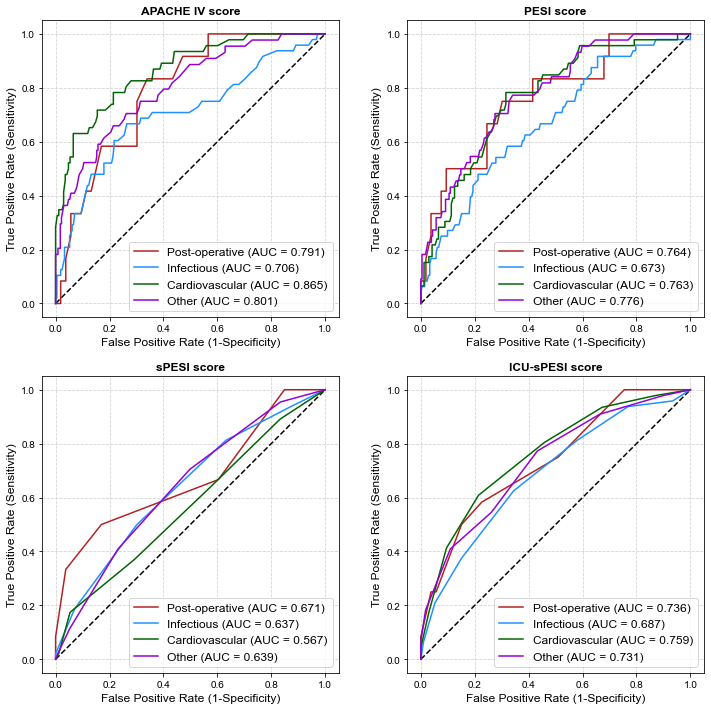

<Figure size 432x288 with 0 Axes>

In [17]:
# initialize the plots with axes, labels etc.
plt.rc('legend', fontsize = 12)
fig, ((ax_roc_apache, ax_roc_pesi),
      (ax_roc_spesi, ax_roc_icu_spesi)) = plt.subplots(2, 2, figsize=(12,12))
 
lst_roc_axes = [ax_roc_apache, ax_roc_pesi, ax_roc_spesi, ax_roc_icu_spesi]
      
for ax in lst_roc_axes:
    ax.plot([0, 1], [0, 1], "k--")
    ax.set_xlabel("False Positive Rate (1-Specificity)", fontsize=12)
    ax.set_ylabel("True Positive Rate (Sensitivity)", fontsize=12)
    ax.grid(color='lightgray', linestyle='dashed')
    ax.axis("square")
    
ax_roc_apache.set_title("APACHE IV score", fontsize=12, fontweight='bold')
ax_roc_pesi.set_title("PESI score", fontsize=12, fontweight='bold')
ax_roc_spesi.set_title("sPESI score", fontsize=12, fontweight='bold')
ax_roc_icu_spesi.set_title("ICU-sPESI score", fontsize=12, fontweight='bold')

# create a dictionary to iterate over
dict_dfs_admdx = {
    "Post-operative": [df_admdx_surgery, 1.5, "firebrick"], 
    "Infectious": [df_admdx_infection, 1.5, "dodgerblue"], 
    "Cardiovascular": [df_admdx_cards, 1.5, "darkgreen"], 
    "Other": [df_admdx_other, 1.5, "darkviolet"]
                 }

dict_roc_results_by_cohort = {} #  dictionary to save certain stats for poential later comparisons/computing

for cohort_type, values in dict_dfs_admdx.items():
    df_temp = values[0].copy()
    linethickness = values[1]
    color_group = values[2]
    admdx_name = cohort_type

    # vector of the true outcome
    np_temp_outcome = df_temp["hospitaldischargestatus"].to_numpy()

    # APACHE-IV
    np_temp_apache_score_raw = df_temp.apachescore.to_numpy()
    fpr_apache, tpr_apache, _ = metrics.roc_curve(np_temp_outcome, np_temp_apache_score_raw)
    auc_apache = metrics.roc_auc_score(np_temp_outcome, np_temp_apache_score_raw)

    # PESI Score 
    np_temp_pesi_score_raw = df_temp[f"PESI_score"].to_numpy()
    fpr_pesi, tpr_pesi, _ = metrics.roc_curve(np_temp_outcome, np_temp_pesi_score_raw)
    auc_pesi = metrics.roc_auc_score(np_temp_outcome, np_temp_pesi_score_raw)

    # sPESI score
    np_temp_spesi_score_raw = df_temp[f"sPESI_score"].to_numpy()
    fpr_spesi, tpr_spesi, _ = metrics.roc_curve(np_temp_outcome, np_temp_spesi_score_raw)
    auc_spesi = metrics.roc_auc_score(np_temp_outcome, np_temp_spesi_score_raw)

    # ICU-sPESI score
    np_temp_icu_spesi_raw = df_temp[f"ICU_sPESI_score"].to_numpy()
    fpr_icu_spesi, tpr_icu_spesi, _ = metrics.roc_curve(np_temp_outcome, np_temp_icu_spesi_raw)
    auc_icu_spesi = metrics.roc_auc_score(np_temp_outcome, np_temp_icu_spesi_raw)
    
    # adding the results to a dictionary for future calculations
    dict_roc_results_by_cohort[admdx_name] = {
        "dataframe": values[0].copy(),
        "arr_true_outcome": np_temp_outcome,
        "arr_apachescore": np_temp_apache_score_raw,
        "fpr_apache": fpr_apache,
        "tpr_apache": tpr_apache,
        "auc_apache": auc_apache,
        "arr_pesi": np_temp_pesi_score_raw,
        "fpr_pesi": fpr_pesi,
        "tpr_pesi": tpr_pesi,
        "auc_pesi": auc_pesi,
        "arr_spesi": np_temp_spesi_score_raw,
        "fpr_spesi": fpr_spesi,
        "tpr_spesi": tpr_spesi,
        "auc_spesi": auc_spesi,
        "arr_icu_spesi": np_temp_icu_spesi_raw,
        "fpr_icu_spesi": fpr_icu_spesi,
        "tpr_icu_spesi": tpr_icu_spesi,
        "auc_icu_spesi": auc_icu_spesi,
    }

    # ROC curves
    ax_roc_apache.plot(
        fpr_apache, 
        tpr_apache, 
        label="{} (AUC = {})".format(cohort_type, round(auc_apache, 3)),
        c=color_group,
        lw=linethickness,
    )

    ax_roc_spesi.plot(
        fpr_spesi, 
        tpr_spesi, 
        label="{} (AUC = {})".format(cohort_type, round(auc_spesi, 3)),
        c=color_group,
        lw=linethickness,
    )

    ax_roc_pesi.plot(
        fpr_pesi, 
        tpr_pesi, 
        label="{} (AUC = {})".format(cohort_type, round(auc_pesi, 3)),
        c=color_group,
        lw=linethickness,
    )

    ax_roc_icu_spesi.plot(
        fpr_icu_spesi, 
        tpr_icu_spesi, 
        label="{} (AUC = {})".format(cohort_type, round(auc_icu_spesi, 3)),
        c=color_group,
        lw=linethickness,
    )


# Adding the legend
ax_roc_apache.legend()
ax_roc_pesi.legend()
ax_roc_spesi.legend()
ax_roc_icu_spesi.legend()

plt.show()
plt.clf()

## AUROC comparisons in each cohort (score vs score)

In [18]:
# iterate over the subgroups and perform the comparisons

lst_rows_auc_score_comparisons = []

for cohort, dict_cohort_attributes in tqdm(dict_roc_results_by_cohort.items()):
    
    # load the data/stats we saved in the computation for the ROC curves
    auc_apache = dict_cohort_attributes["auc_apache"]
    auc_pesi = dict_cohort_attributes["auc_pesi"]
    auc_spesi = dict_cohort_attributes["auc_spesi"]
    auc_icu_spesi = dict_cohort_attributes["auc_icu_spesi"]
    
    np_temp_outcome = dict_cohort_attributes["arr_true_outcome"]
    
    np_temp_apache_score_raw = dict_cohort_attributes["arr_apachescore"] 
    np_temp_pesi_score_raw = dict_cohort_attributes["arr_pesi"] 
    np_temp_spesi_score_raw = dict_cohort_attributes["arr_spesi"] 
    np_temp_icu_spesi_raw = dict_cohort_attributes["arr_icu_spesi"]
    
    # AUROC comparisons
    p_val_apache_pesi = compare_AUCs_paired(auc1=auc_apache, 
                                        auc2=auc_pesi, 
                                        y_true=np_temp_outcome, 
                                        test1=np_temp_apache_score_raw, 
                                        test2=np_temp_pesi_score_raw, 
                                        kind_scoring="interval")

    p_val_apache_spesi = compare_AUCs_paired(auc1=auc_apache, 
                                            auc2=auc_spesi, 
                                            y_true=np_temp_outcome, 
                                            test1=np_temp_apache_score_raw, 
                                            test2=np_temp_spesi_score_raw, 
                                            kind_scoring="ordinal")

    p_val_pesi_spesi = compare_AUCs_paired(auc1=auc_pesi, 
                                           auc2=auc_spesi, 
                                           y_true=np_temp_outcome, 
                                           test1=np_temp_pesi_score_raw, 
                                           test2=np_temp_spesi_score_raw, 
                                           kind_scoring="ordinal")

    p_val_apache_icu_spesi = compare_AUCs_paired(auc1=auc_apache, 
                                                 auc2=auc_icu_spesi, 
                                                 y_true=np_temp_outcome, 
                                                 test1=np_temp_apache_score_raw, 
                                                 test2=np_temp_icu_spesi_raw, 
                                                 kind_scoring="ordinal")

    p_val_pesi_icu_spesi = compare_AUCs_paired(auc1=auc_pesi, 
                                               auc2=auc_icu_spesi, 
                                               y_true=np_temp_outcome, 
                                               test1=np_temp_pesi_score_raw, 
                                               test2=np_temp_icu_spesi_raw, 
                                               kind_scoring="ordinal")

    p_val_spesi_icu_spesi = compare_AUCs_paired(auc1=auc_spesi, 
                                                auc2=auc_icu_spesi, 
                                                y_true=np_temp_outcome, 
                                                test1=np_temp_spesi_score_raw, 
                                                test2=np_temp_icu_spesi_raw, 
                                                kind_scoring="ordinal")
    
    row_auc_score_comparisons = pd.DataFrame({
        "Cohort": cohort,
        "APACHE_vs_PESI": p_val_apache_pesi,
        "APACHE_vs_sPESI": p_val_apache_spesi,
        "APACHE_vs_ICU_sPESI": p_val_apache_icu_spesi,
        "PESI_vs_sPESI": p_val_pesi_spesi,
        "PESI_vs_ICU_sPESI": p_val_pesi_icu_spesi,
        "sPESI_vs_ICU_sPESI": p_val_spesi_icu_spesi,
    }, index=[0])
    
    lst_rows_auc_score_comparisons.append(row_auc_score_comparisons)

df_auc_score_comparison = pd.concat(lst_rows_auc_score_comparisons)
df_auc_score_comparison.round(4)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 78.61it/s]


,Cohort,APACHE_vs_PESI,APACHE_vs_sPESI,APACHE_vs_ICU_sPESI,PESI_vs_sPESI,PESI_vs_ICU_sPESI,sPESI_vs_ICU_sPESI
0,Post-operative,0.7667,0.2972,0.6023,0.2876,0.7003,0.2931
0,Infectious,0.5061,0.2588,0.7245,0.4490,0.7097,0.1945
0,Cardiovascular,0.0185,0.0000,0.0327,0.0001,0.9269,0.0000
0,Other,0.5955,0.0042,0.1594,0.0016,0.2147,0.0104
